<a href="https://colab.research.google.com/github/ehabsameh/Congressional-analytics/blob/main/Remotework_Impact_on_HousingPrices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import needed packages
!pip install pyjanitor==0.23.1
import pandas as pd
import json
from urllib.request import urlopen
import matplotlib.pyplot as plt
import plotly.express as px
from urllib import request
import json
import numpy as np
import seaborn as sns
import janitor
import datetime
import statsmodels.api as sm



In [ ]:
#Import work form home and relocation data
url2021="https://api.census.gov/data/2021/acs/acs1?get=NAME,B08006_017E,B07001_049E,B07001_065E,B01001_001E,B18120_003E,C07401_001E,C07401_031E,C07401_041E&for=county:*&in=state:*"
url2019="https://api.census.gov/data/2019/acs/acs1?get=NAME,B08006_017E,B07001_049E,B07001_065E,B01001_001E,B18120_003E,C07401_001E,C07401_031E,C07401_041E&for=county:*&in=state:*"
url2018="https://api.census.gov/data/2018/acs/acs1?get=NAME,B08006_017E,B07001_049E,B07001_065E,B01001_001E,B18120_003E,C07401_001E,C07401_031E,C07401_041E&for=county:*&in=state:*"
url2017="https://api.census.gov/data/2017/acs/acs1?get=NAME,B08006_017E,B07001_049E,B07001_065E,B01001_001E,B18120_003E,C07401_001E,C07401_031E,C07401_041E&for=county:*&in=state:*"
url2016="https://api.census.gov/data/2016/acs/acs1?get=NAME,B08006_017E,B07001_049E,B07001_065E,B01001_001E,B18120_003E,C07401_001E,C07401_031E,C07401_041E&for=county:*&in=state:*"

response2021 = urlopen(url2021)
response2019 = urlopen(url2019)
response2018 = urlopen(url2018)
response2017 = urlopen(url2017)
response2016 = urlopen(url2016)
data_json2021 = json.loads(response2021.read())
data_json2019 = json.loads(response2019.read())
data_json2018 = json.loads(response2018.read())
data_json2017 = json.loads(response2017.read())
data_json2016 = json.loads(response2016.read())
data_json2021.pop(0)
data_json2019.pop(0)
data_json2018.pop(0)
data_json2017.pop(0)
data_json2016.pop(0)
cols = ['District Name','worked_from_home','moved_in_within_state','moved_in_diff_state','population','employed','population_1_year_ago','moved_out_same_state','moved_out_diff_state','State code', 'County Code']
data2021 = pd.DataFrame(data_json2021, columns = cols)
data2021['year'] =2021
data2019 = pd.DataFrame(data_json2019, columns = cols)
data2019['year'] =2019
data2018 = pd.DataFrame(data_json2018, columns = cols)
data2018['year'] =2018
data2017 = pd.DataFrame(data_json2017, columns = cols)
data2017['year'] =2017
data2016 = pd.DataFrame(data_json2016, columns = cols)
data2016['year'] =2016
data5years = pd.concat([data2021,data2019,data2018,data2017,data2016],ignore_index=True, axis=0)
data5years[['County', 'State']] = data5years['District Name'].str.split(',', expand=True)
data5years['State'] = data5years['State'].str.strip()
data5years['County'] = data5years['County'].str.strip()
wfh_relocation_df = data5years[['year','population','employed','worked_from_home','moved_in_within_state','moved_in_diff_state','population_1_year_ago','moved_out_same_state','moved_out_diff_state','County', 'State']]
wfh_relocation_df

In [ ]:
#Import house sales data
housing_df = pd.read_csv("https://files.zillowstatic.com/research/public_csvs/zhvi/County_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv?t=1677108411")
state_abbr_to_name = {'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas','CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 
'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 
'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 
'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 
'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 
'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'}
housing_df['State'] = housing_df['State'].map(state_abbr_to_name)
housing_df.rename(columns = {'RegionName':'County'}, inplace = True)

# Pivot longer
housing_df= housing_df.pivot_longer(
    index=["County", "State"],
    column_names=slice("2000-01-31", "2023-01-31"),
    names_to=("Month"),
    values_to=("Median_Home_Price")
   )
housing_df['Date'] = pd.to_datetime(housing_df.Month)
housing_df['year'] = housing_df.Date.dt.year
housing_df= housing_df.groupby(['year','County','State'],as_index = False)['Median_Home_Price'].mean()
housing_df['Price_Change'] = 100*housing_df.groupby(['State','County'])['Median_Home_Price'].pct_change()
housing_df[(housing_df['State'] == 'California') & (housing_df['County'] == 'San Francisco County') ]

In [16]:
# Import new construction home sales data

path='/content/sample_data/new_const_final.xlsx'
new_const = pd.read_excel(path)

In [55]:
#Merge "Home sales data", "Work from Home" and "Relocation" data

merged_df1 = pd.merge(wfh_relocation_df,housing_df, on=["State", "County","year" ] )
df_n = merged_df1.loc[:, ~merged_df1.columns.isin(['year', 'County','State'])]

merged_df = pd.merge(merged_df1,new_const, on=["State", "County","year" ] )

# Convert to numeric
col = df_n.columns
merged_df[col] = merged_df[col].apply(pd.to_numeric, errors='coerce')
merged_df = merged_df.fillna(0)

# adding calculated variables
merged_df['WFH_Ratio'] = 100*merged_df['worked_from_home']/merged_df['employed']
merged_df['Total_IN_NW'] = merged_df['moved_in_within_state']+merged_df['moved_in_diff_state']
merged_df['Total_OUT_NW'] = merged_df['moved_out_same_state']+merged_df['moved_out_diff_state']
merged_df['Total_IN_Ratio'] = 100*(merged_df['moved_in_within_state']+merged_df['moved_in_diff_state'])/merged_df['population_1_year_ago']
merged_df['Total_OUT_Ratio'] = 100*(merged_df['moved_out_same_state']+merged_df['moved_out_diff_state'])/merged_df['population_1_year_ago']
merged_df['Net_Relo_IN_OUT_NW'] = merged_df['Total_IN_NW'] - merged_df['Total_OUT_NW']
merged_df['Net_Relo_IN_OUT_St'] = merged_df['moved_in_within_state'] - merged_df['moved_out_same_state']
merged_df['Net_Relo_IN_OUT_St_Ratio'] = 100*(merged_df['moved_in_within_state'] - merged_df['moved_out_same_state'])/merged_df['population_1_year_ago']
merged_df['Net_Relo_IN_OUT_NW_Ratio'] = 100*(merged_df['Total_IN_NW'] - merged_df['Total_OUT_NW'])/merged_df['population_1_year_ago']
merged_df['New_Const_Homes_sold_Ratio'] = 100*merged_df['new_const_home_sold']/merged_df['population_1_year_ago']
merged_df['Adj_Net_Relo_IN_OUT_NW_Ratio']= merged_df['Net_Relo_IN_OUT_NW_Ratio'] - merged_df['New_Const_Homes_sold_Ratio']


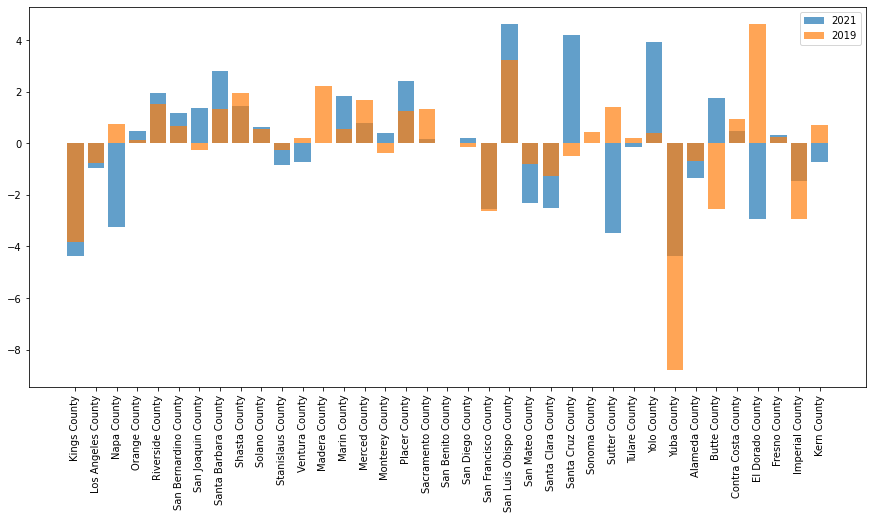

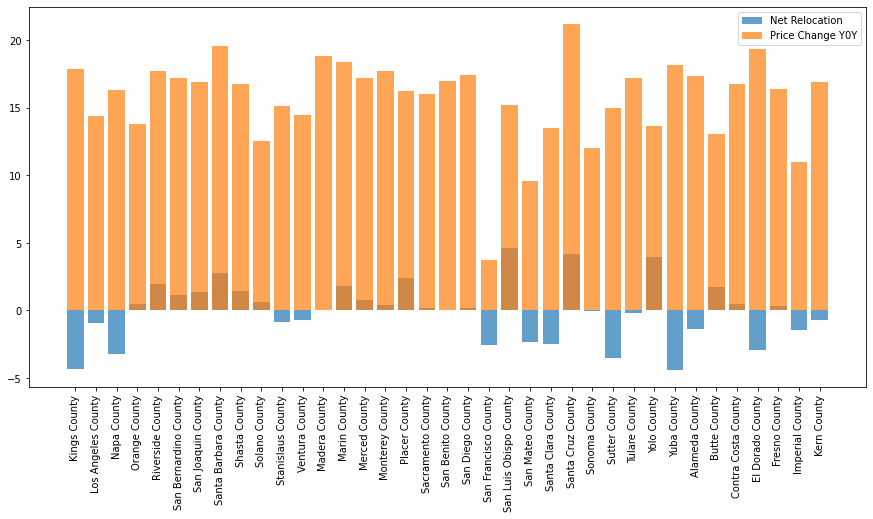

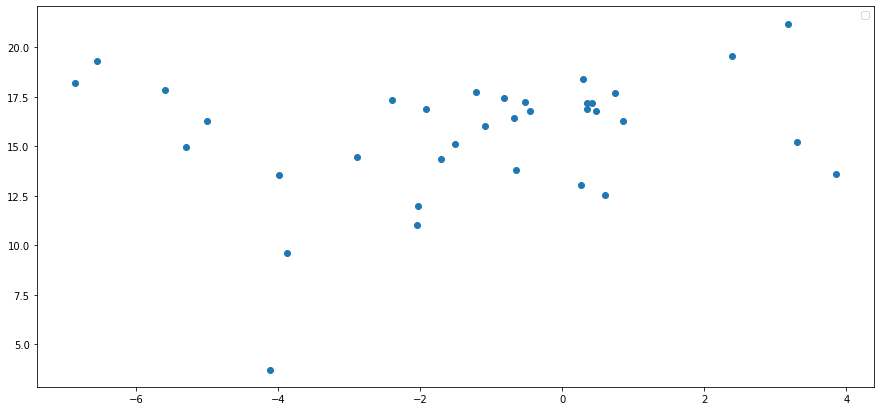

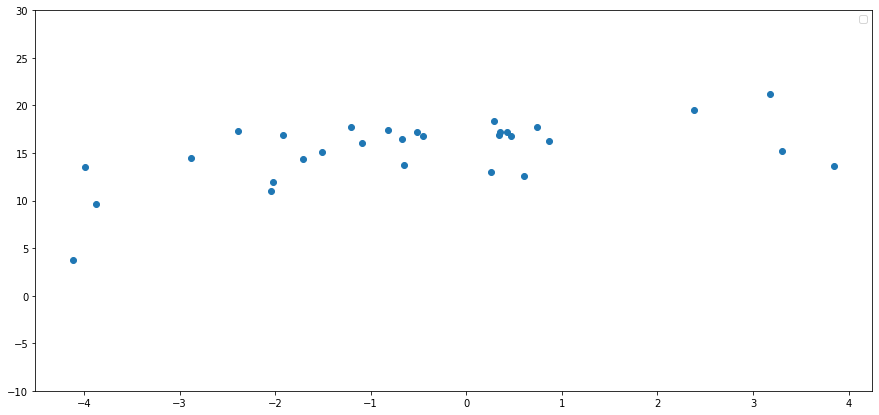

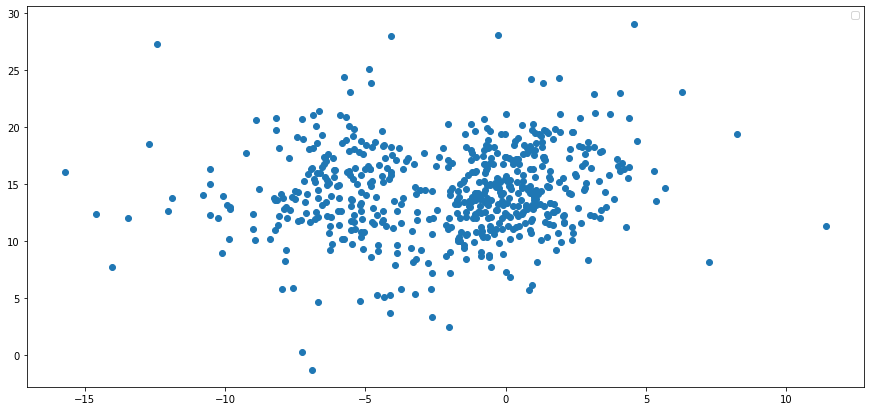

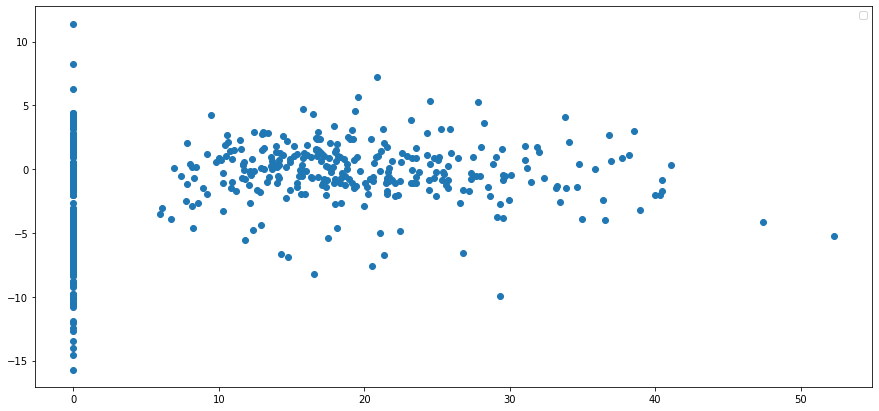

In [81]:
# sanity check

#year_to_include = [2021,2019]
#filter = merged_df[(merged_df['State'] == "California") & (merged_df['year'].isin(year_to_include))]
filter0 = merged_df[(merged_df['year']== 2021)]
filter1 = merged_df[(merged_df['State'] == "California") & (merged_df['year']== 2021)]
filter2 = merged_df[(merged_df['State'] == "California") & (merged_df['year']== 2019)]
filter3 = merged_df[(merged_df['State'] == "California") & (merged_df['Net_Relo_IN_OUT_NW_Ratio']>= -5) & (merged_df['year']== 2021)]
filter4 = merged_df[(merged_df['State'] == "California") & (merged_df['Net_Relo_IN_OUT_NW_Ratio']>= -5) & (merged_df['year']== 2021)& (merged_df['WFH_Ratio']> 0)]

#plt.plot(filter['year'], filter['worked_from_home'])
#fig, ax = plt.subplots(figsize=(15, 9))
plt.rcParams['figure.figsize'] = [15, 7]
plt.bar(x=filter1['County'],height= filter1['Net_Relo_IN_OUT_St_Ratio'], label = "2021", alpha=0.7)
plt.bar(x=filter2['County'],height= filter2['Net_Relo_IN_OUT_St_Ratio'], label= "2019", alpha = 0.7)
plt.xticks(rotation=90)
plt.legend()
plt.show()


plt.rcParams['figure.figsize'] = [15, 7]
plt.bar(x=filter1['County'],height= filter1['Net_Relo_IN_OUT_St_Ratio'], label = "Net Relocation", alpha=0.7)
plt.bar(x=filter1['County'],height= filter1['Price_Change'], label= "Price Change Y0Y", alpha = 0.7)
plt.xticks(rotation=90)
plt.legend()
plt.show()

plt.rcParams['figure.figsize'] = [15, 7]
plt.scatter(filter1['Net_Relo_IN_OUT_NW_Ratio'],filter1['Price_Change'])
plt.legend()
plt.show()

plt.rcParams['figure.figsize'] = [15, 7]
plt.scatter(filter3['Net_Relo_IN_OUT_NW_Ratio'],filter3['Price_Change'])
plt.ylim((-10,30))
plt.legend()
plt.show()


plt.rcParams['figure.figsize'] = [15, 7]
plt.scatter(filter0['Net_Relo_IN_OUT_NW_Ratio'],filter0['Price_Change'])
plt.legend()
plt.show()


plt.rcParams['figure.figsize'] = [15, 7]
plt.scatter(filter0['WFH_Ratio'],filter0['Net_Relo_IN_OUT_NW_Ratio'])
plt.legend()
plt.show()






In [79]:
# Regression

df = sm.add_constant(filter4) 
df = df.dropna()  
# Create a linear regression model 


model = sm.OLS.from_formula('Price_Change ~ WFH_Ratio + Net_Relo_IN_OUT_NW_Ratio + State + year + New_Const_Homes_sold_Ratio + Net_Relo_IN_OUT_NW_Ratio:New_Const_Homes_sold_Ratio ', df)
#model = sm.OLS.from_formula('Price_Change ~ State ', df)

# Fit the model 
results = model.fit()  
# Print the regression summary 
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           Price_Change   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     6.249
Date:                Sat, 25 Feb 2023   Prob (F-statistic):            0.00292
Time:                        22:10:48   Log-Likelihood:                -62.923
No. Observations:                  27   AIC:                             133.8
Df Residuals:                      23   BIC:                             139.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
